In [8]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=e7b525ece58308de685eec0e88cdfac038aed3230a9a19aae45a49ed7415fbc0
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=56d9cf081b0318205e5aab6ec9ec820cd56706bd1e23e6b7c3153157b5986f52
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [17]:
import networkx as nx # https://networkx.org/documentation/stable/tutorial.html
import numpy as np
import random
import argparse
import pickle
import torch
from gensim.models import Word2Vec # https://radimrehurek.com/gensim/
import pandas as pd
from matplotlib import pyplot as plt
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

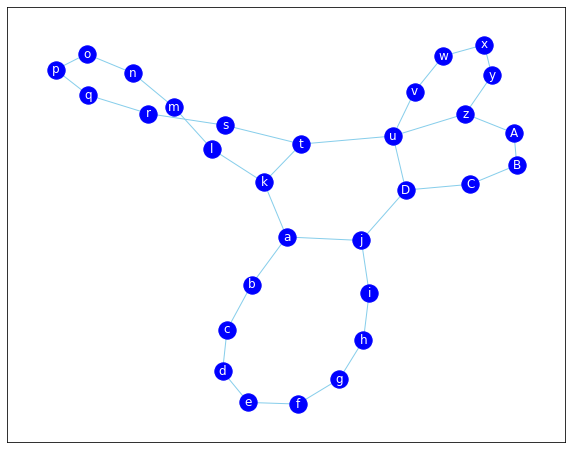

In [10]:
import networkx
import string

all_nodes = string.ascii_letters[:30]
a_nodes = all_nodes[:10]
b_nodes = all_nodes[10:20]
c_nodes = all_nodes[20:]

all_edges = []
for node_set in [a_nodes, b_nodes, c_nodes]:
    # Link each node to the next
    for i, node in enumerate(node_set[:-1]):
        all_edges.append((node, node_set[i + 1], 2))
    # Finish off the circle
    all_edges.append((node_set[0], node_set[-1], 2))

joins = [(a_nodes[0], b_nodes[0], 8), (b_nodes[-1], c_nodes[0], 8), (c_nodes[-1], a_nodes[-1], 8)]

all_edges += joins
# One extra edge for C:
all_edges.append((c_nodes[0], c_nodes[5], 5))

G = networkx.Graph()
for edge in all_edges:
    G.add_edge(edge[0], edge[1], len=edge[2])
plt.figure(figsize=(10,8))
nx.draw_networkx(G=G, node_color='blue', width=1.0, edge_color='skyblue', font_color='white')
plt.show()

In [5]:
# Reference : https://github.com/Manu-Fraile/Network-Representation-Learning/blob/master/DeepWalk/main.py
# https://github.com/rlagywns0213/2021_Summer_Internship/blob/main/Graph%20Neural%20Network/RandomWalk/Deepwalk/train.py
# sg parameter if 1 skip gram for Word2Vec https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# hs parameter if 1 hierarchical softmax
class DeepWalk(torch.nn.Module):
    def __init__(self, G, w = 10, d = 128, gamma = 30, t = 6):
      super(DeepWalk, self).__init__()
      self.G = G  
      self.w = w    #window size
      self.d = d    # embedding size
      self.gamma = gamma    # walks per vertex
      self.t = t  # walk length
      self.embedding = None
      self.wvmodel = None

    def randomWalk(self, st_v): 
      one_walk = []
      current_node = st_v 
      one_walk.append(str(st_v)) 
      for j in range(self.t - 1): # self.t = walk_length 
        neighbors = list(self.G.edges([st_v])) 
        if (len(neighbors) > 0): 
          random_edge = random.choice(neighbors) 
          if (random_edge[0] == current_node): 
            current_node = random_edge[1] 
          else : 
            current_node = random_edge[0] 
        one_walk.append(str(current_node))
      return one_walk

    def fit(self): 
      walks = []
      nodes = list(self.G.nodes())
      print('starting', len(self.G.nodes))
      for i in range(self.gamma): 
        random.shuffle(nodes)
        for node in nodes: 
          walks.append(self.randomWalk(node)) 

      self.wvmodel = Word2Vec(walks, size=self.d, window=self.w, sg=1, hs=1)
      self.embedding = self.wvmodel.wv.vectors

    def get_vectors(self): 
      return self.embedding

    def get_wvmodel(self): 
      return self.wvmodel



starting 30


Text(0.5, 1.0, 'Representations of My Graph')

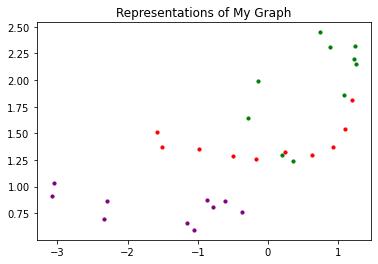

In [30]:
# dimension 2 embedding and plot it 
w = DeepWalk(G, 5, 2, 100, 5)
w.fit()
wvmodel = w.get_wvmodel()
x_coords = []
y_coords = []
word_vectors = [wvmodel.wv[v] for v in wvmodel.wv.vocab.keys()]
pca = PCA(n_components=2)
edge_list = wvmodel.wv.vocab
pca_result = pca.fit_transform(word_vectors)
for i in list(G.nodes()):
    vec = wvmodel.wv[i]
    x, y = vec[0], vec[1]
    if i in string.ascii_letters[:10]:
      plt.scatter(x,y, s=10, c='red')
    elif i in string.ascii_letters[10:20]:
      plt.scatter(x,y, s=10, c='green')
    elif i in string.ascii_letters[20:]:
      plt.scatter(x,y, s=10, c='purple')
plt.title("Representations of My Graph")

starting 30
(30, 128)
(30, 2)


Text(0.5, 1.0, 'Representations of My Graph')

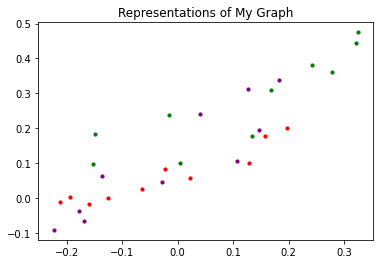

In [31]:
# dimension 128 embedding and reduce it with UMAP method 
# then plot it
 
w = DeepWalk(G, 5, 128, 100, 5)
w.fit()
ver_rep = w.get_vectors() 
model = w.get_wvmodel()
print(ver_rep.shape)

umap_2d = umap.UMAP(n_components=2, random_state=42)
ver_rep = umap_2d.fit_transform(ver_rep)
print(ver_rep.shape)
x_coords = []
y_coords = []
word_vectors = [model.wv[v] for v in model.wv.vocab.keys()]
pca = PCA(n_components=2)
edge_list = model.wv.vocab
pca_result = pca.fit_transform(word_vectors)
for i in list(G.nodes()):
    vec = model.wv[i]
    x, y = vec[0], vec[1]
    if i in string.ascii_letters[:10]:
      plt.scatter(x,y, s=10, c='red')
    elif i in string.ascii_letters[10:20]:
      plt.scatter(x,y, s=10, c='green')
    elif i in string.ascii_letters[20:]:
      plt.scatter(x,y, s=10, c='purple')
plt.title("Representations of My Graph")


starting 30
(30, 128)
(30, 3)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


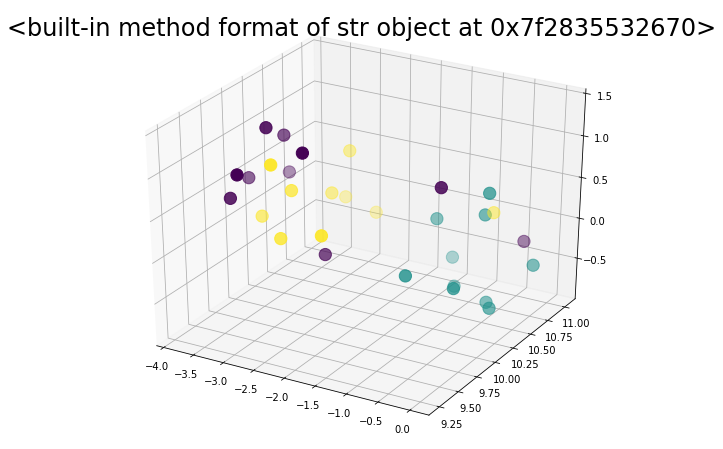

In [37]:
# embedding with 128 dimension and reduce it to 3 dimension using UMAP 
# then plot it 

w = DeepWalk(G, 5, 128, 30, 5)
w.fit() 
ver_rep = w.get_vectors() 
model = w.get_wvmodel()
print(ver_rep.shape)

umap_3d = umap.UMAP(n_components=3, random_state=42)
ver_rep = umap_3d.fit_transform(ver_rep)
print(ver_rep.shape)

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
x, y, z = ver_rep[:,0], ver_rep[:,1], ver_rep[:,2]
labels = [0]*10 + [1]*10 + [2]*10
print(labels)
ax.scatter(x,y,z, s=150, c=labels)
plt.title('representations for the graph '.format, fontsize=24)
plt.show()

[1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 21, 25, 23, 24, 27, 28, 29, 26, 30, 31, 32, 14, 15, 18, 20, 22, 33]


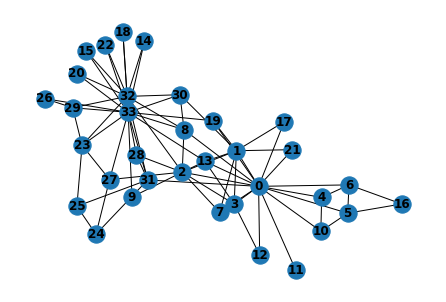

In [38]:
# Create a networkx graph object
karate_graph = nx.Graph() 
 
edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
karate_graph.add_edges_from(edge_list)
 
# Draw the resulting graph
nx.draw(karate_graph, with_labels=True, font_weight='bold')
print(list(karate_graph.nodes()))

starting 34


Text(0.5, 1.0, 'Representations of Karate Graph')

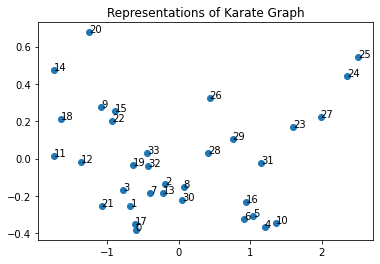

In [41]:
w = DeepWalk(karate_graph, 5, 2, 100, 5)
w.fit() 
wvmodel = w.get_wvmodel()
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

x_coords = []
y_coords = []
word_vectors = [wvmodel.wv[v] for v in wvmodel.wv.vocab.keys()]
pca = PCA(n_components=2)
edge_list = wvmodel.wv.vocab
pca_result = pca.fit_transform(word_vectors)
for x,y in pca_result:
    x_coords.append(x)
    y_coords.append(y)
plt.scatter(x_coords, y_coords)
for i,v in enumerate(edge_list):
    plt.annotate(v,xy=(x_coords[i],y_coords[i]))
plt.title("Representations of Karate Graph")

starting 34


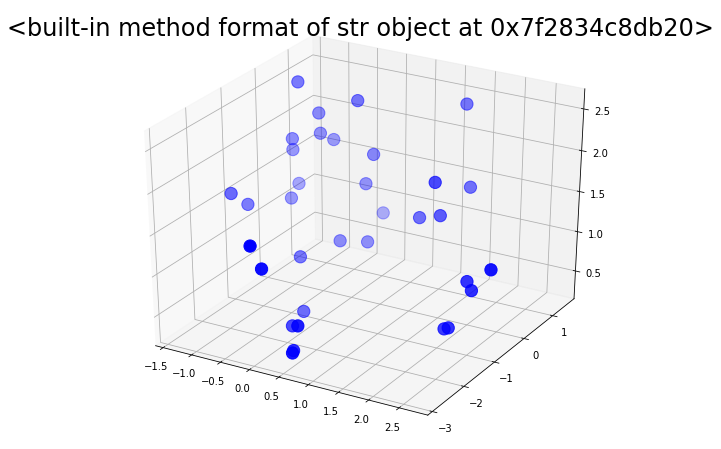

In [42]:
w = DeepWalk(karate_graph, 5, 3, 100, 5)
w.fit() 
wvmodel = w.get_wvmodel()
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
vectors = wvmodel.wv.vectors
x, y, z = vectors[:,0], vectors[:,1], vectors[:,2]
ax.scatter(x,y,z, s=150, c='blue')
plt.title('representations for the graph '.format, fontsize=24)
plt.show()